In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from ontological_processor import OntologicalProcessor
from preprocess_transcription import Preprocessor

# Loading Data

In [4]:
link_to_stuff = '../sample_transcriptions/2021-11-02.txt'
proc = Preprocessor(link_to_stuff)

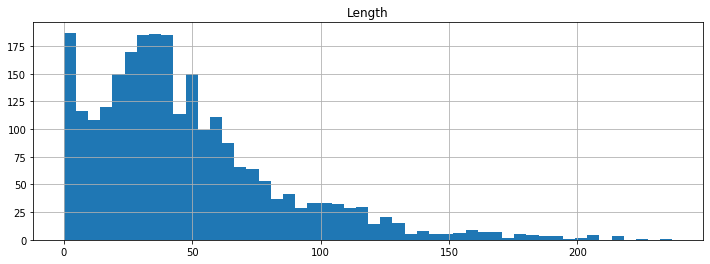

In [14]:
proc.plot_length_distribution()

In [5]:
df = proc.get_transcriptions(15)

# Processing

In [6]:
op = OntologicalProcessor()

In [7]:
df['turn'] = df['Transcriptions'].apply(op.find_turn)
df['altitude'] = df['Transcriptions'].apply(op.find_alt)

C:\Users\Michael.Lutz22\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


IndexError: list index out of range

In [11]:
df['Transcriptions'].iloc[2]

'AMERICAN 1583 MAINTAIN 180 KNOTS TO ZALPO CONTACT TOWER NOW 127.5 HAVE AH GOOD DAY'

In [19]:
command = df['Transcriptions'].iloc[0]
command = str.split(command, " ")

In [23]:
alt_loc = [i for i, x in enumerate('Transcriptions') if x.isdigit()]

In [24]:
alt_loc

[]

In [64]:
find_alt(df['Transcriptions'].iloc[4])

DELTA 1169 MAINTAIN 7000
['delta', '1169', 'maintain', '7000']
[1, 3]
[2]
[1, -1]


In [65]:
def find_alt(command):
    print(command)
    command = str.lower(command)
    command = str.split(command)

    print(command)

    alt_loc = [i for i, x in enumerate(command) if x.isdigit() and len(x)>3]

    # locate the index of ascend
    ascend_loc = [i for i, x in enumerate(command) if (x=='descend') or (x=='ascend') or (x=='climb') or (x=='altitude') or (x=='maintain')]

    """# creates a list of all the numbers in the command
    final_list = []
    for index in alt_loc:
        final_list.append(command[index])"""

    print(alt_loc)
    print(ascend_loc)

    # if there is no altitude command, then return 0
    # else return the element in final_list closest to an element in ascend_loc
    if len(ascend_loc) == 0:
        return None
    else:
        distances = [ascend_loc[-1]-y for y in alt_loc]
        # Find the smallest positive element of distances
        min_dist = min([i for i, x in enumerate(distances) if x>0])


NameError: name 'final_list' is not defined

In [18]:
command = df['Transcriptions'].iloc[4]
print(find_alt(command))

['1169', '7000']


In [104]:
command

'AMERICAN 14 03 DESCEND AND MAINTAIN 7000'

In [75]:
df

,Time,Transcriptions,Length,altitude,turn
51,21-11-02 07:14:45.389,DELTA 1169 APPROACH GOOD MORNING 35 RIGHT,41,True,True
52,21-11-02 07:14:45.698,AMERICAN 1583 AH MILES FROM 3 MAINTAIN 3000 UN...,110,False,False
53,21-11-02 07:14:45.866,AMERICAN 1583 MAINTAIN 180 KNOTS TO ZALPO CONT...,82,False,False
54,21-11-02 07:14:46.199,AMERICAN 14 03 DESCEND AND MAINTAIN 7000,40,False,False
55,21-11-02 07:14:46.364,DELTA 1169 MAINTAIN 7000,24,False,False
56,21-11-02 07:14:46.599,CITATION 7MM HEADING 330 AND INTERCEPT THE LOC...,52,True,True
57,21-11-02 07:14:46.759,AMERICAN 14 03 REDUCE SPEED TO 1 9 0 HEADING 260,48,True,True
58,21-11-02 07:14:47.112,ENVOY 3746 APPROACH GOOD MORNING DESCEND VIA 7...,167,True,True
59,21-11-02 07:14:47.268,REGIONAL APPROACH AMERICAN 1374 OUT OF 6300 DE...,82,False,False
60,21-11-02 07:14:47.547,AMERICAN 1374 REGIONAL APPROACH GOOD MORNING 3...,52,True,True
